# Data-driven business -- ProRail Hersteltijd 

**********************************************************************************************************
**********************************************************************************************************

![1200px-ProRaillogo](notebook-images/1200px-ProRail_logo.png) 
![hu-logo-en](notebook-images/hu-logo-en.png)

***********************************************************************************************************
***********************************************************************************************************

## <span style='font-family:font_family name'> Groep : V2A-PG3 </span>
## <span style='font-family:font_family name'> Emiel Verhoef , Studentnummer : 1760229  </span>
## <span style='font-family:font_family name'> Stan Haakman , Studentnummer : 1781254 </span>
## <span style='font-family:font_family name'> Khai-Tam Nguyen , Studentnummer : 1789287 </span>
## <span style='font-family:font_family name'> Hussin Almoustafa , Studentnummer : 1776495 </span>




# Business Understanding

## Doel 
De doelstelling van het project is om de planners een inschatting te geven over de duur van de storing zodat zei vervolgens de hervatting van het treinverkeer kunnen organiseren. Uit de huidige situatie blijkt dat de voorspellingen van de monteurs vaak te pessimistisch zijn en daardoor zijn storingen vaak eerder opgelost dan voorspelt.

De vraag van ProRail en de planners van de NS is:
Kunnen we op basis van de data een 'betere' voorspelling maken van de functiehersteltijd waardoor we het hervatten van de dienstregeling soepeler kunnen laten verlopen.
![1](notebook-images/1.png)


**tekortkomingen huidige situatie**

In de huidige situatie bij Pro-rail is gebleken dat de prognose van de monteur pessimistisch is. Dit beteken dat de monteur te veel hersteltijd inschat en het treinverkeer al eerder hervat had kunnen worden.

**toekomstige situatie**

Ons doel is om op basis van de aangeleverde data een betere voorspelling te doen dan de huidige prognose van Pro-Rail. Dit doen we zodat de planning mogelijk sneller het treinverkeer weer in kan gaan plannen en daardoor is de vertraging eerder opgelost. 


# Stakeholders + classificatie (primair/ secundair):

- **1** Prorail meldkamer (Primair)
- **2** Ns  (Secundair)
- **3** Riesgers  (Secundair)
- **4** Planners   (Primair)
- **5** Machinisten  (Secundair)
- **6** Aannemersbedrijf  (Secundair) 


# Stakeholders analyse (Mendelow’s matrix)

|*Belang*|laag|matig|hoog|zeer hoog|
|---|---|---|---|---|
|**Invloed**|||||
|laag| **(6)**  |   |   |   |
|matig|   |**(5)**   | **(3)**  |   |
|hoog|   | **(2)**  | **(4)**  |  |
|zeer hoog|   |   |   | **(1)**  |




## Data understanding 
In de fase Data Understanding zullen we kijken naar de inhoud van de data die beschikbaar is. Deze stap is van cruciaal belang om onverwachte problemen te voorkomen tijdens de volgende fase - Data preparation - die doorgaans het langste deel van een project is.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
#ProRail cvs Data file 
df = pd.read_csv('sap_storing_data_hu_project.csv')
df['#stm_sap_meldnr'].sort_index(inplace = True)

C:\Users\emiel\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,11,19,21,24,25,27,32,33,36,37,38,39,40,46,47,48,49,51,53,55,56,60,73,75,78,80,82,83,86,87,91,95,99,102,103,104,107,108,109,110,111,112,113,116,118,119,120,121,122,123,124,129) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
pd.set_option('display.max_rows', df.shape[0]+1) #max aantal rows 

In [4]:
# We halen hier rows met hetzelfde stm_sap_meldnr uit de dataframe, we doen dit omdat dit het train/test proces
# van de ML modellen sterk beïnvloed, je test dan op dezelfde data als je traint, en dat is natuurlijk niet de bedoeling.
len(df['#stm_sap_meldnr'])-len(df['#stm_sap_meldnr'].drop_duplicates())

332045

In [5]:
# We kunnen hier zien dat er heel veel nans zijn in onze data.
df.isna().sum()

Unnamed: 0                              0
#stm_sap_meldnr                         0
stm_mon_nr                              1
stm_vl_post                        588027
stm_sap_meld_ddt                        1
stm_sap_mon_meld_ddt                 1762
stm_sap_meldtekst_lang                140
stm_mon_begin_ddt                  588432
stm_sap_meldtekst                     199
stm_mon_toelichting_trdl           587577
stm_oh_pg_mld                      226444
stm_geo_mld                         11833
stm_geo_mld_uit_functiepl           13600
stm_equipm_nr_mld                  237400
stm_equipm_soort_mld               237403
stm_equipm_omschr_mld              237408
stm_km_van_mld                          4
stm_km_tot_mld                          4
stm_prioriteit                        161
stm_scenario_mon                   862111
stm_status_melding_sap                  4
stm_mon_nr_status_omschr           638113
stm_mon_nr__statuscode             571685
stm_mon_nr_status_wijzdd          

In [6]:
# Als we alle rijen met nans weg halen, dan hebben we geen rijen meer. Daarom zullen we voor elk specifiek model alleen
# de nans weg moeten halen van de kolommen die we gebruiken.
df.dropna().shape[0]

0

In [7]:
# Hier kunnen we ook zien dat er een paar nan values zitten in onze target variabel. 
# dezen zullen we moeten verwijderen.
df['stm_fh_duur'].isna().sum()

38

In [8]:
# Onze target variabel is een float, dus als we classificatie modellen willen gebruiken moeten we dat
# zien om te zetten naar categorieën 
df['stm_fh_duur'].dtypes

dtype('float64')

In [9]:
df['stm_fh_duur'].describe()

count    898488.000000
mean        923.148771
std        6404.546787
min           0.000000
25%          11.000000
50%          84.000000
75%         256.000000
max      528297.000000
Name: stm_fh_duur, dtype: float64

In [10]:
# We kunnen hier zien dat de correlatie tussen onze target variabel en de data erg laag is.
# Waarschijnlijk kunnen we dan niet een linear regressie model gebruiken.
df.corr()['stm_fh_duur'].sort_values(ascending=False)

stm_fh_duur                  1.000000
stm_arbeid                   0.076406
#stm_sap_meldnr              0.065408
stm_oorz_code                0.028632
stm_x_actueel_ind            0.023105
stm_geo_mld_uit_functiepl    0.023062
stm_progfh_gw_teller         0.022379
stm_geo_gst_uit_functiepl    0.021116
stm_km_tot_gst               0.017142
stm_km_tot_mld               0.015090
stm_mon_nr__statuscode       0.014891
stm_km_van_gst               0.014012
stm_contractgeb_gst          0.012619
stm_km_van_mld               0.011923
stm_equipm_nr_mld            0.007824
stm_equipm_nr_gst            0.007632
stm_contractgeb_mld          0.006723
stm_x_bk                     0.006135
stm_reactie_duur             0.001232
stm_schadenr                -0.000327
stm_progfh_gw_lwd_datum     -0.002555
stm_rapportage_maand        -0.002616
stm_x_run_id                -0.003208
stm_prioriteit              -0.006820
stm_fh_status               -0.007453
stm_rapportage_jaar         -0.007671
stm_x_verval

# Conclusies

We hebben gezien dat er te veel duplicates zijn. Deze zullen we hoogst waarschijnlijk moeten verwijderen. 
Verder hebben we ook veel nans gezien. Het probleem hiermee is elke rij een nan heeft. We kunnen dus niet zo maar alle rijen met nans weghalen.  

Onze target variabele is een float, dus voor classificatie algoritmes zullen we het categorial moeten maken.  
Verder zien we ook dat het gemiddelde van onze target variabele rond de 900 ligt en dat onze grootste hersteltijd 530000 minuten is. Dit betekent dat er outliers zijn die een heel groot effect hebben op onze dataset.  

Verder zien we ook dat de huidige correlatie van onze target variabel erg laag is met de rest van de data. Waarschijnlijk is een linear regressie model niet mogelijk. We kiezen er voor om te kijken naar verschillende classificatie modellen

## Helper functies:

In [11]:
# Functie om outliers te verwijderen 
def column_outlier(strength, dataframe, columns):
    temp_dataframe = dataframe.copy()
    try:
        if strength == 's':
            strength=3
        elif strength == 'a':
            strength=1.5
    except:
        print("Invalid strength")
    for column in columns:
        Q1 = temp_dataframe[column].quantile(0.25)
        Q3 = temp_dataframe[column].quantile(0.75)
        IQR = Q3 - Q1
        temp_dataframe = temp_dataframe[~((temp_dataframe[column] < (Q1 - strength * IQR)) |(temp_dataframe[column] > (Q3 + strength* IQR)))]
    return temp_dataframe

In [12]:
# functie die hetzelfde doet als sklearn accuracy_score MAAR ook nog een paramater heeft voor een foutmarge
# als de target bijvoorbeeld 15 is en de predict 13, met een foutmarge van 3, dan ziet die dat als een succesvolle classificatie
def get_accuracy(r,zip_list):
    return len([ _ for x in zip_list if x[0]+r >= x[1] >= x[0]-r])/len(zip_list)

In [13]:
# Functie om dummies te creëren voor een kolom
def create_dummies(target_df, source_df, column):
    return target_df.join(pd.get_dummies(source_df.iloc[target_df.index][column]))

## Data preparation (en meer understanding)
Data preparation is het opschonen, structureren en verrijken van ruwe data tot een gewenste output voor analyse. Het wordt gewoonlijk 'conciërgewerk' genoemd, maar het is enorm belangrijk en cruciaal voor de missie om robuuste, nauwkeurige downstream-analyses te garanderen. Als datavoorbereiding op de juiste manier wordt uitgevoerd, krijgt u inzicht in de aard van uw gegevens, zodat u er betere vragen over kunt stellen.


In [14]:
# Hier halen we alle duplicates weg in de kolom #stm_sap_meldnr
df.drop_duplicates(subset = '#stm_sap_meldnr', keep = 'last',inplace = True)
len(df['#stm_sap_meldnr'])-len(df['#stm_sap_meldnr'].drop_duplicates())

0

We gaan Natuurlijk de hersteltijd voorspelen. dus laten we de kolom [stm_fh_duur] opschonen en daarna plotten.

In [15]:
# We willen alleen durations die niet gelijk zijn aan 0 en kleiner zijn dan 8 uur
df = df[(df.stm_fh_duur != 0) & (df.stm_fh_duur <= 480)]

In [16]:
import seaborn as sns 

Hoe is de fh_duur verdeeld?

<AxesSubplot:xlabel='stm_fh_duur', ylabel='Density'>

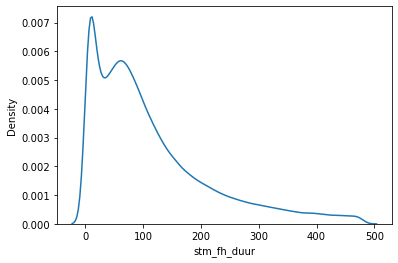

In [17]:
sns.kdeplot(df.stm_fh_duur)

In [18]:
# Ik zorg er hier voor dat de 'stm_progfh_in_duur' kolom naar floats gecast wordt
df.stm_progfh_in_duur = df.stm_progfh_in_duur.apply(lambda x: float(str(x).replace('-','').replace('*','').strip()))
df.stm_progfh_in_duur.dtypes

dtype('float64')

De kolom [stm_sap_melddatum] bevat de datum van de melding , Hier gaan we de datum naar sezoenen en week nummer converteren.

In [19]:
# voeg dummy kolommen voor seizoenen toe
df.stm_sap_melddatum = pd.to_datetime(df.stm_sap_melddatum)

df['date_offset'] = (df.stm_sap_melddatum.dt.month*100 + df.stm_sap_melddatum.dt.day - 320)%1300

df['seizoen_melding'] = pd.cut(df.copy()['date_offset'], [0, 300, 602, 900, 1300], 
                      labels=['spring', 'summer', 'autumn', 'winter'])

df.drop(['date_offset'], axis=1)
df = df.join(pd.get_dummies(df.seizoen_melding))
df['seizoen_melding'].value_counts()

summer    93837
spring    92732
winter    89686
autumn    88033
Name: seizoen_melding, dtype: int64

In [20]:
# maak een kolom voor weeknummers van de melding, deze hebben mogelijk een grotere impact op onze modellen dan de seizoenen
df['weeknr']= df.stm_sap_melddatum.dt.isocalendar().week.apply(lambda x: 'w' + str(x))

Nu kunnen we de vertaling van kolommen [stm_techn_mld],[stm_contractgeb_gst],[stm_geo_mld],[stm_oorz_code] toevoegen door een externe data's set's

In [21]:
# join de oorzaakcodes
o_df = pd.read_csv('Oorzaakcodes.csv', sep = ';')
o_df = o_df.rename(columns={'Code': 'stm_oorz_code'})
df = df.merge(o_df, on = 'stm_oorz_code', how = 'outer')

In [22]:
# join de goetrajectcodes
geo_df = pd.read_csv('geocodes.csv',sep = ';') 
geo_df = geo_df.rename(columns={'Code': 'stm_geo_mld'}) 
df = df.merge(geo_df, on = 'stm_geo_mld', how = 'outer') 

In [23]:
# join de Contractgebiedcodes
cg = pd.read_excel('Contractgebiedcodes.xlsx') 
cg = cg.rename(columns={'Code': 'stm_contractgeb_gst'})
df = df.merge(cg, on = 'stm_contractgeb_gst', how = 'outer') 

In [24]:
# join de techniekvelden
tgv_df = pd.read_csv('techniekvelden.csv', sep = ';')
tgv_df = tgv_df.rename(columns={'Letter': 'stm_techn_mld'})
df = df.merge(tgv_df, on = 'stm_techn_mld', how = 'outer') 

In [25]:
# kijken wat de gemiddelde fh_duur is voor de verschillende oorzaken
mean_oorzaak_df = df.copy()[['stm_fh_duur', 'Oorzaak']].groupby('Oorzaak', as_index = False).mean()

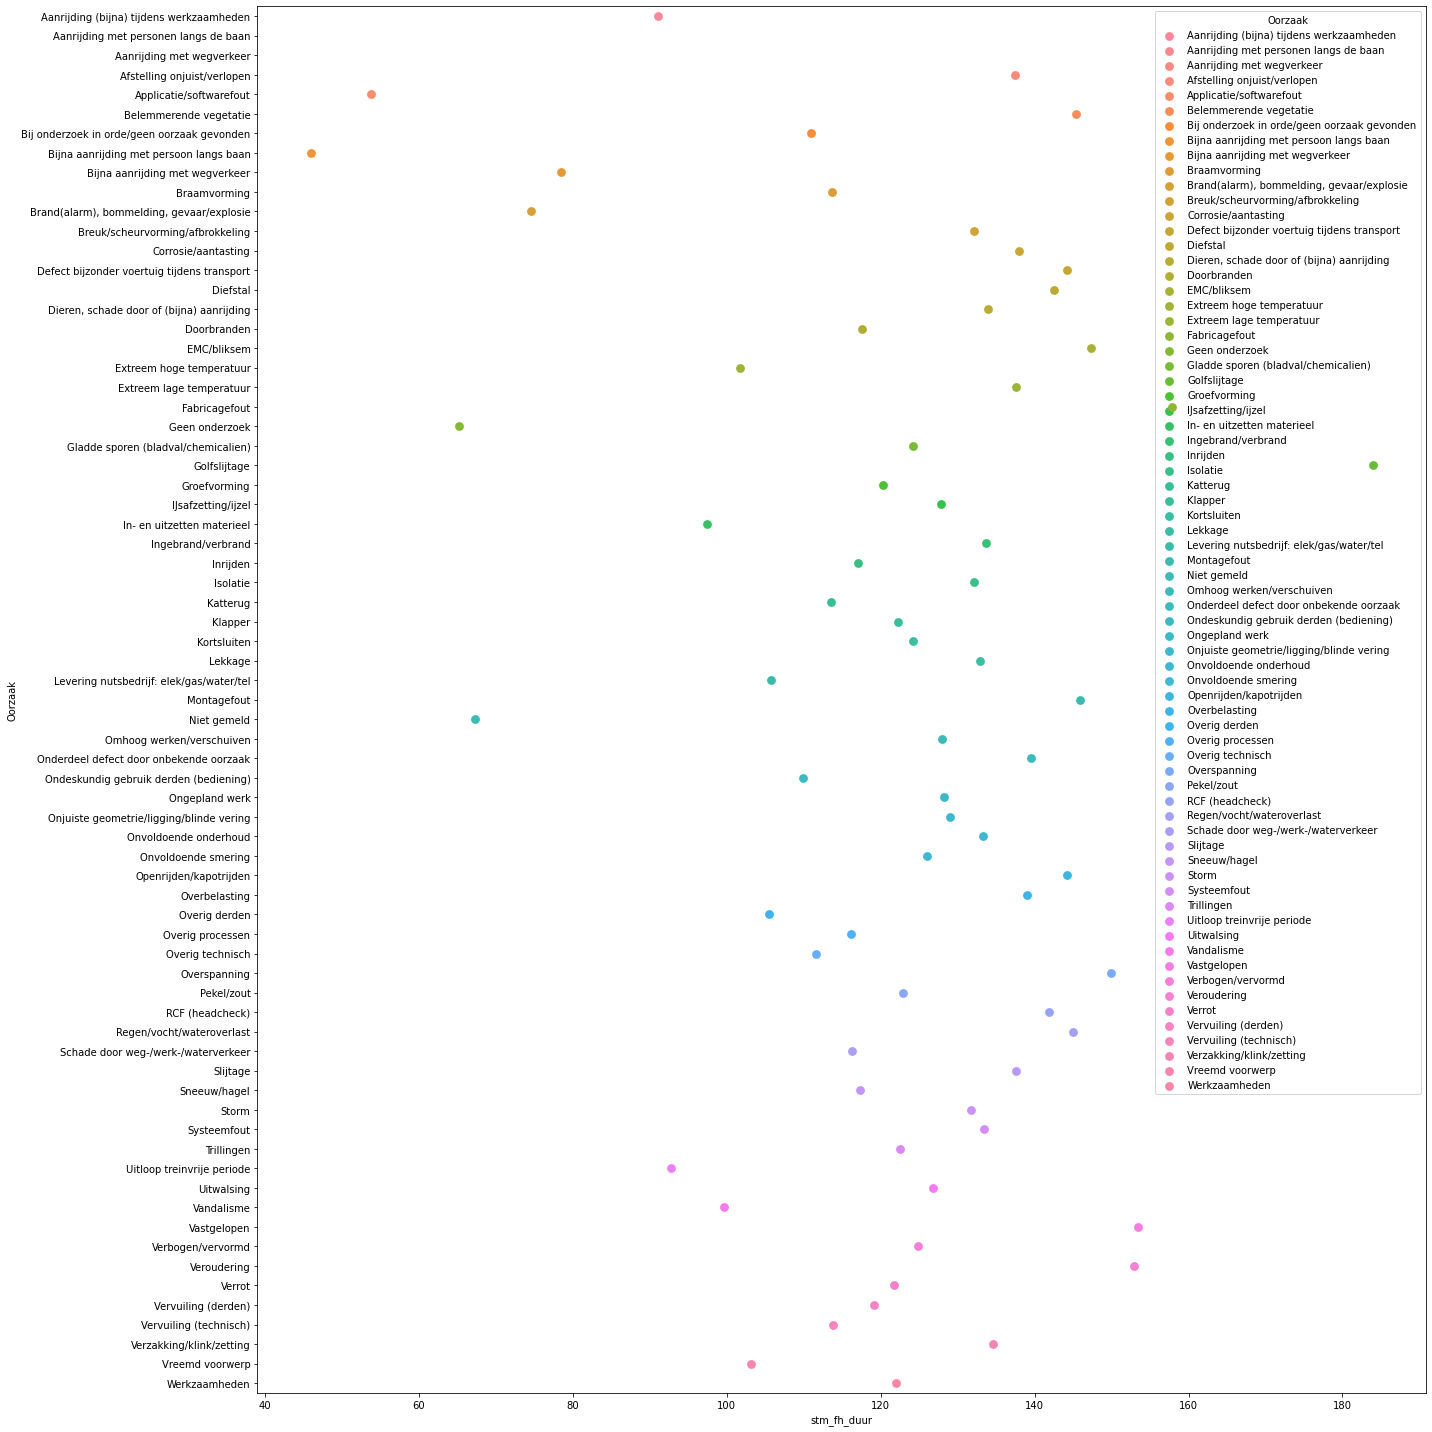

In [26]:
x = 'Oorzaak'
y = 'stm_fh_duur'
plt.figure(figsize=(20,20))
new_data= mean_oorzaak_df.sort_values(by ='stm_fh_duur' , ascending=False)
new_data_sort=mean_oorzaak_df
ax=sns.pointplot(x = new_data_sort['stm_fh_duur'], y = new_data_sort['Oorzaak'], hue=new_data_sort['Oorzaak'])
plt.tight_layout()
plt.show()

In [27]:
# kijken wat de gemiddelde fh_duur is voor de verschillende trajecten
mean_traject_df = df.copy()[['stm_fh_duur', 'Traject']].groupby('Traject', as_index = False).mean()

<AxesSubplot:xlabel='stm_fh_duur', ylabel='Contractgebied'>

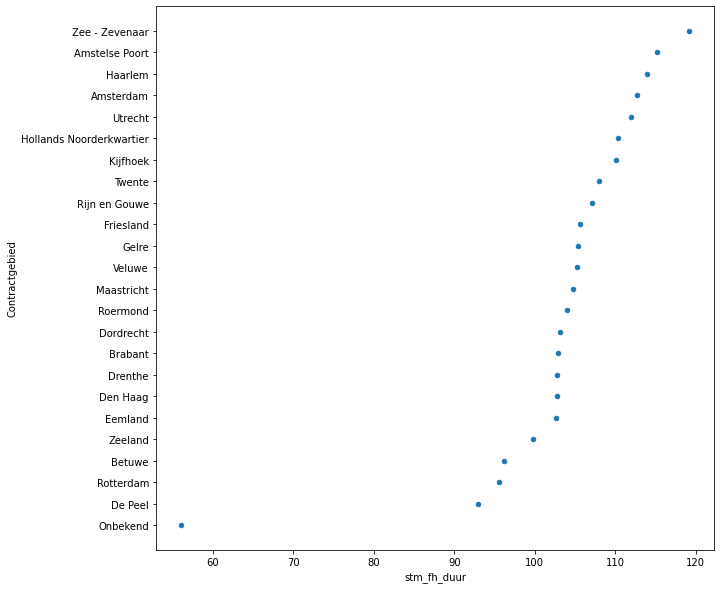

In [28]:
mean_Contractgebied_df = column_outlier('a', df.copy(), ['stm_fh_duur'])[['stm_fh_duur', 'Contractgebied']].groupby('Contractgebied', as_index = False).mean()

#Plot de data
x = 'stm_fh_duur'
y = 'Contractgebied'

tplot = mean_Contractgebied_df[['stm_fh_duur','Contractgebied']]
tplot.sort_values(['stm_fh_duur'], ascending=True, inplace=True)
tplot.dropna(inplace=True)

tplot.plot(x=x, y=y, kind='scatter',figsize=(10,10))

In [29]:
df[['stm_techn_mld','Techniekveld OH plangroep']].value_counts()

stm_techn_mld  Techniekveld OH plangroep
S              Seinwezen                    104352
B              Baan                          67838
P              Post 21                       38362
T              Telecom                       33485
E              Energievoorziening            22688
K              Kunstwerken                   15779
O              Operationeel beheer           10082
G              Gebouwen                       2718
M              MR                             1961
I              Ondergrondse infra              321
X              Onbekend                        252
A              ATM                              76
dtype: int64

In [30]:
# kolom voor het uur op een dag de een melding binnenkomt, misschien relevant als de input van een ML model.
df['meldtijd_h'] = df.stm_sap_meldtijd.str.split(':').str[0]

Om een accurate tijdstip te kunnen voorspelen maken we bins van 5 minuten. We hebben voor deze lengte gekozen omdat het een makkelijk begrijpbaar getal is, en we 10 minuten net niet flexibel genoeg vonden (wat als we een error van 15 min acceptabel vinden? Je kan niet anderhalve bin nemen)

In [31]:
# maak target var bins zodat we classification kunnen gebruiken
error_margin  = 5
bins = [x for x in range(0,481,error_margin)]
labels = [x for x in range(1,len(bins))]
df['duration_bin'] = pd.cut(df['stm_fh_duur'], bins = bins, labels=labels)

In [32]:
#bins voor het voorspellen van de reactie_duur, hier komen we later op terug
error_margin1  = 5
bins1 = [x for x in range(0,481,error_margin1)]
labels1 = [x for x in range(1,len(bins1))]
df['duration_bin_reactie'] = pd.cut(df['stm_reactie_duur'], bins = bins1, labels=labels1)


## Model comparison



We hebben naar modellen gekeken zoals: Random Forests, KNN, Decision Trees, Support Vector Machines, Naive Bayes en regression modellen. We tonen hier alleen maar de modellen die wij als relevant beschouwen.

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import r2_score
import pickle

<h5> Decision Tree </h5>

In [34]:
# Onze data slice met de numriek kolomen 
dt_df = df.copy()[['duration_bin', 'stm_reactie_duur', 'stm_prioriteit','stm_km_van_mld', 'stm_km_tot_mld']].dropna()

In [35]:
# dummies maken  
dt_df = create_dummies(dt_df,df,['Traject','meldtijd_h','stm_equipm_soort_mld', 'weeknr', 'stm_techn_mld', 'Oorzaak'])

dt_df = dt_df.dropna()
    
df.stm_fh_status = df.stm_fh_status.apply(lambda x: f"status: {x}")
dt_df = create_dummies(dt_df,df,['stm_fh_status'])

Onze target variabel is : 

In [36]:
X = dt_df.drop(columns = ['duration_bin']) #feauters 
y = dt_df['duration_bin'] #Target 

Data splitsen naar trainen set and test set :


In [37]:
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X, y, test_size=0.2, random_state = 0)
clf = DecisionTreeClassifier(max_depth = 13, random_state = 0) #Hyperparameter : 13 
clf.fit(X_train_dt, y_train_dt)  

DecisionTreeClassifier(max_depth=13, random_state=0)

In [38]:
y_pred_dt = clf.predict(X_test_dt)
y1_ax = [get_accuracy(x, list(zip(list(y_test_dt), y_pred_dt))) for x in range(0,30)] 

In [39]:
#om onze model op te slaan !! 
# filename = 'Trained_ML_algorithms/decision_tree.sav'
# pickle.dump(clf, open(filename, 'wb'))


In [40]:
#kans dat de precited bin hetzelfde is als de echte bin, in onze test set.
accuracy_score(y_test_dt,y_pred_dt) 

0.15669445471096327

<h5> KNN</h5>


In [41]:
# svm, random forests en gaussion process classifier duren veels te lang op deze dataset

kn_df = df[['duration_bin','stm_equipm_nr_mld','stm_reactie_duur', 'stm_prioriteit', 'stm_km_tot_mld','spring', 'summer','autumn','winter']].dropna()

X = kn_df.drop(columns = ['duration_bin'])
y = kn_df.duration_bin


Data splitsen naar trainen set and test set :


In [42]:
X_train_kn, X_test_kn, y_train_kn, y_test_kn = train_test_split(X, y, test_size=0.2)

clf2 = KNeighborsClassifier(n_neighbors = 13).fit(X_train_kn, y_train_kn)


In [43]:
y_pred_kn = clf2.predict(X_test_kn)
y2_ax = [get_accuracy(x, list(zip(list(y_test_kn), y_pred_kn))) for x in range(0,30)]

In [44]:
#kans dat de precited bin hetzelfde is als de echte bin, in onze test set.
accuracy_score(y_test_kn,y_pred_kn)

0.0807435669025329

<h5> Voorspellen reactieduur met DT</h5>

Hier is een Decision Tree  model die de kolom [stm_reactie_duur] zou voorspellen  

In [45]:
dt_df1 = df.copy()[['duration_bin_reactie', 'stm_km_tot_mld', 'stm_km_van_mld']].dropna()
dt_df1 = create_dummies(dt_df1,df,['Traject','meldtijd_h','stm_equipm_soort_mld', 'weeknr', 'stm_techn_mld', 'Oorzaak'])
dt_df1 = dt_df1.dropna()

target variabel is :

In [46]:
X1 = dt_df1.drop(columns = ['duration_bin_reactie'])
y1 = dt_df1['duration_bin_reactie']


Data splitsen naar trainen set and test set :


In [47]:
X_train_db, X_test_db, y_train_db, y_test_db = train_test_split(X1, y1, test_size=0.2)
clf1 = DecisionTreeClassifier(max_depth = 13, random_state = 0).fit(X_train_db, y_train_db) 

In [48]:
#om onze model op te slaan !! 
# filename = 'Trained_ML_algorithms/decision_tree_duration_bin_reactie.sav'
# pickle.dump(clf1, open(filename, 'wb'))


In [49]:
y_pred_db = clf1.predict(X_test_db)

#kans dat de precited bin hetzelfde is als de echte bin, in onze test set.
accuracy_score(y_test_db,y_pred_db)

0.20123313095724937

<h5> versimpelde DT</h5>

Niet erg anders dan de originele DT maar met een stuk minder inputs

In [50]:
dt_df2 = df.copy()[['duration_bin','stm_reactie_duur','stm_prioriteit']].dropna()
    
dt_df2 = create_dummies(dt_df2,df,['weeknr','Oorzaak', 'Contractgebied'])

dt_df2 = dt_df2.dropna()

target variabel is : 

In [51]:
X2 = dt_df2.drop(columns = ['duration_bin'])
y2 = dt_df2['duration_bin']

Data splitsen naar trainen set and test set met gekozen hyperparameters, we gebruiken min_samples_leaf om overfitting tegen te gaan :

In [52]:
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X2, y2, test_size=0.2, random_state = 0)
clf3 = DecisionTreeClassifier(random_state = 0, min_samples_leaf = 75, max_depth = 13)
clf3.fit(X_train_f.values, y_train_f)

DecisionTreeClassifier(max_depth=13, min_samples_leaf=75, random_state=0)

In [53]:
#om onze model op te slaan !! 
# filename = 'Trained_ML_algorithms/mini_decision_tree.sav'
# pickle.dump(clf3, open(filename, 'wb'))

In [54]:
y_pred_f = clf3.predict(X_test_f)
y4_ax = [get_accuracy(x, list(zip(list(y_test_f), y_pred_f))) for x in range(0,30)]

In [55]:
#kans dat de precited bin hetzelfde is als de echte bin, in onze test set.
accuracy_score(y_test_f,y_pred_f) 

0.15247833764527124

## Evalueren van verschillende modellen

<h5> Regular DT predictions vs weighted DT probabilities </h5>

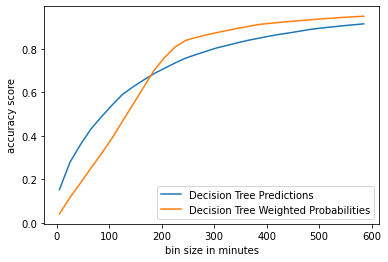

,probability_bin,pred_bin,actual_bin,prob_bin_error,pred_bin_error
count,73053.000000,73053.000000,73053.000000,73053.000000,73053.000000
mean,22.890080,13.625341,22.901633,9.173887,9.857405
std,15.093877,15.871928,20.429440,10.224357,13.951371
min,1.000000,1.000000,1.000000,0.000000,0.000000
25%,13.000000,2.000000,8.000000,3.000000,1.000000
50%,20.000000,9.000000,17.000000,7.000000,5.000000
75%,27.000000,17.000000,31.000000,10.000000,12.000000
max,95.000000,96.000000,96.000000,86.000000,95.000000


In [56]:
# deze functie neemt niet de bin die de DT als meest waarschijnlijk beschouwt, maar de sum van (de probability van een bin * het bin nummber) voor elke bin
def get_weighted_prob_bin(prob_list):

    return round(sum([(count+1) * i for count,i in enumerate(prob_list)]))

prob_df = pd.DataFrame({'probability_bin':[get_weighted_prob_bin(i) for i in clf3.predict_proba(X_test_f)], 'pred_bin':clf3.predict(X_test_f), 'actual_bin':y_test_f})
prob_df = prob_df.astype('int')

prob_df['prob_bin_error'] = abs(prob_df['probability_bin'] - prob_df['actual_bin'])
prob_df['pred_bin_error'] = abs(prob_df['pred_bin'] - prob_df['actual_bin'])

pred_accs = [get_accuracy(i, list(zip(prob_df.pred_bin,prob_df.actual_bin))) for i in range(30)]
prob_accs = [get_accuracy(i, list(zip(prob_df.probability_bin,prob_df.actual_bin))) for i in range(30)]

x_ax = [error_margin +(20*x) for x in range(0,30)]

plt.plot(x_ax,pred_accs, label = 'Decision Tree Predictions')
plt.plot(x_ax,prob_accs, label = 'Decision Tree Weighted Probabilities')

plt.xlabel('bin size in minutes')
plt.ylabel('accuracy score')

plt.legend()
plt.show()
prob_df.describe()

Zoals je hier kan zien werkt het weighted probabilities model pas beter vanaf een te grote bin-size/foutmarge (ongeveer 180 min). Daarom hebben we besloten deze methode niet te gebruiken voor onze applicatie.

<h5>DT vs versimpelde DT vs kNN vs Prorail prognose</h5>


In [57]:
bins = [x for x in range(0,480,error_margin)]
labels = [x for x in range(1,len(bins))]
prog_df = df.copy()[['stm_progfh_in_duur','duration_bin']]
prog_df = column_outlier('a', prog_df.copy(), ['stm_progfh_in_duur'])
prog_df['prog_duration_bin'] = pd.cut(prog_df['stm_progfh_in_duur'], bins = bins, labels=labels)
prog_df = prog_df.dropna()
prog_df = prog_df[['duration_bin', 'prog_duration_bin']]

y3_ax = [get_accuracy(x, list(zip(list(prog_df.duration_bin), list(prog_df.prog_duration_bin)))) for x in range(0,30)]

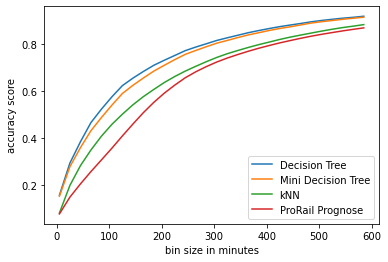

In [58]:
x_ax = [error_margin +(20*x) for x in range(0,30)]


plt.plot(x_ax,y1_ax, label = 'Decision Tree')
plt.plot(x_ax,y4_ax, label = 'Mini Decision Tree')
plt.plot(x_ax,y2_ax, label = 'kNN')
plt.plot(x_ax,y3_ax, label = 'ProRail Prognose')


plt.xlabel('bin size in minutes')
plt.ylabel('accuracy score')

plt.legend()
plt.show()


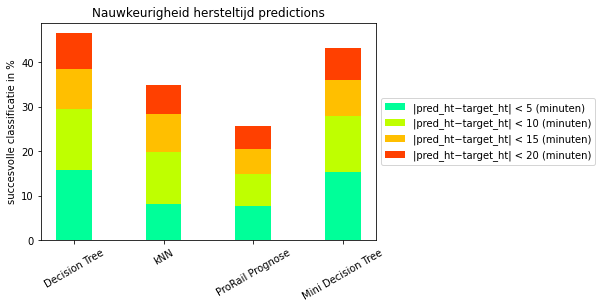

In [59]:
labels = ['Decision Tree','kNN', 'ProRail Prognose', 'Mini Decision Tree']

bar_1 = [100 * eval(f"y{i}_ax[0]") for i in range(1,len(labels)+1)]
bar_2 = [100 * (eval(f"y{i}_ax[1]") - eval(f"y{i}_ax[0]")) for i in range(1,len(labels)+1)]
bar_3 = [100 * (eval(f"y{i}_ax[2]") - eval(f"y{i}_ax[1]")) for i in range(1,len(labels)+1)]
bar_4 = [100 * (eval(f"y{i}_ax[3]") - eval(f"y{i}_ax[2]")) for i in range(1,len(labels)+1)]

width = 0.4  

fig, ax = plt.subplots()

ax.bar(labels, bar_1, width, label=f'|pred_ht−target_ht| < {error_margin} (minuten)', color = '#00ff99')
ax.bar(labels, bar_2, width ,bottom=bar_1,label=f'|pred_ht−target_ht| < {2*error_margin} (minuten)', color = '#bfff00')
ax.bar(labels, bar_3, width ,bottom=(np.array(bar_2) + np.array(bar_1)),label=f'|pred_ht−target_ht| < {3*error_margin} (minuten)', color = '#ffbf00')
ax.bar(labels, bar_4, width ,bottom=(np.array(bar_2) + np.array(bar_1) + np.array(bar_3)),label=f'|pred_ht−target_ht| < {4*error_margin} (minuten)', color = '#ff4000')


ax.set_ylabel('succesvolle classificatie in %')
ax.set_title('Nauwkeurigheid hersteltijd predictions')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=30)

plt.show()

In [60]:
# basiskans voor een juiste classificatie door de meest voorkomende bin te raden
max(df.duration_bin.dropna().value_counts())/len(df.duration_bin.dropna())

0.05046714133591746

In [61]:
# decision tree
[y1_ax[0],y1_ax[1],y1_ax[2]]

[0.15669445471096327, 0.2939099010307585, 0.38429633279947434]

In [62]:
# kNN
[y2_ax[0],y2_ax[1],y2_ax[2]]

[0.0807435669025329, 0.1984805956602854, 0.2824176008874397]

In [63]:
# prorail prognose
[y3_ax[0],y3_ax[1],y3_ax[2]]

[0.07684074069669256, 0.14848027147778584, 0.20461924526955508]

In [64]:
#mini decision tree
[y4_ax[0],y4_ax[1],y4_ax[2]]

[0.15247833764527124, 0.2782363489521306, 0.3593144703160719]

## Conclusie

Na dat we onze modellen hebben geëvalueerd kunnen we concluderen dat onze mini decision tree model het meest geschikte model is voor onze applicatie. De grotere decision tree an geeft wel iets betere resultaten, maar heeft ook veel meer inputs. Dit zou in de praktijk geen probleem zijn omdat de data automatisch kan worden ingevuld, maar voor onze demo model is dat een stuk meer werk. Omdat wij de reactie_duur kolom gebruiken als input voor ons model kunnen we de hersteltijd voorspelling pas relatief laat in het proces doen, daarom hebben we ook besloten om een model te trainen die de reactieduur voorspelt.

# Deployment 

Onze eind product zou een website zijn die verschillende modes heeft om de resultaat van de voorspellingen te toenen. 

gebruikte techniken : 
- Flask  (web framework)
- pickle (Object Serialization) 
- javascript /Css /Html 


1 **Easymode**  : 
![Easymode](notebook-images/Easymode.png) 

2 **Easymode Resultaat ** : 
![eaysemode2](notebook-images/eaysemode2.png)